<a href="https://colab.research.google.com/github/ziatdinovmax/Semi-Supervised-VAE-nanoparticles/blob/main/ssrVAE_paper_synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2023

- Semi-supervised VAE with rotational and translational invariances
- Based on [PyroVED library](https://github.com/ziatdinovmax/pyroVED) by Maxim Ziatdinov
- Applied to synthetic dataset of card suites
- The proof-of-concept analysis by Maxim Ziatdinov
- Analysis of robustness with respect to noise and distrotions by Yongtao Liu
- Supported by the [CSSAS EFRC center](https://www.cssas-efrc.com/)

# Semi-supervised VAE for model data with orientational disorder


---

This notebook demonstrates how to use a variational autoencoder (VAE) to generalize from a small subset of labeled data with the weak orientational disorder to a large volume of unlabelled data with a much stronger orientational disorder.

---

In [ ]:
#@title Installations

!pip install -q git+https://github.com/ziatdinovmax/pyroved.git
!pip install -q kornia

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB

In [ ]:
#@title Imports
import pyroved as pv

import kornia as K
import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
tt = torch.tensor



In [ ]:
#@title Helper function
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    !gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
    !unzip -o -qq cards.zip
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


def transform_images(*args, **kwargs):
    card1, card2, card3, card4 = args
    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = kwargs.get("shear")
    z = kwargs.get("scale")
    n_samples = kwargs.get("samples", 3000)
    torch.manual_seed(kwargs.get("seed", 0))
    # Define transform(s)
    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.augmentation.RandomAffine(a, translate=t, shear=[-s, s, -s, s], scale=z, p=1),
    )
    # Apply random transformations to a batch of 3000 images for each card type
    cards1 = transform(card1[None, None].repeat_interleave(n_samples, dim=0))
    cards2 = transform(card2[None, None].repeat_interleave(n_samples, dim=0))
    cards3 = transform(card3[None, None].repeat_interleave(n_samples, dim=0))
    cards4 = transform(card4[None, None].repeat_interleave(n_samples, dim=0))

    # Concatenate (this is our training set)
    cards_all = torch.cat([cards1, cards2, cards3, cards4]).squeeze().float()
    labels_all = torch.cat([torch.zeros(n_samples), torch.ones(n_samples),
                           2*torch.ones(n_samples), 3*torch.ones(n_samples)])
    return cards_all.flatten(1), pv.utils.to_onehot(labels_all.long(), n=4)


def plot_manifolds(model):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

## Training data

Here, we are going to make our own training data from playing card suits, with monochrome clubs, spades, diamonds, and hearts.  Using a digitized symbols from Word as a starting point, we apply a set of affine transforms including rotation, shear, translation, and scale to prepare our data sets. Note that we are going to apply different sets of distortions to labeled and unlabeled parts of our data.

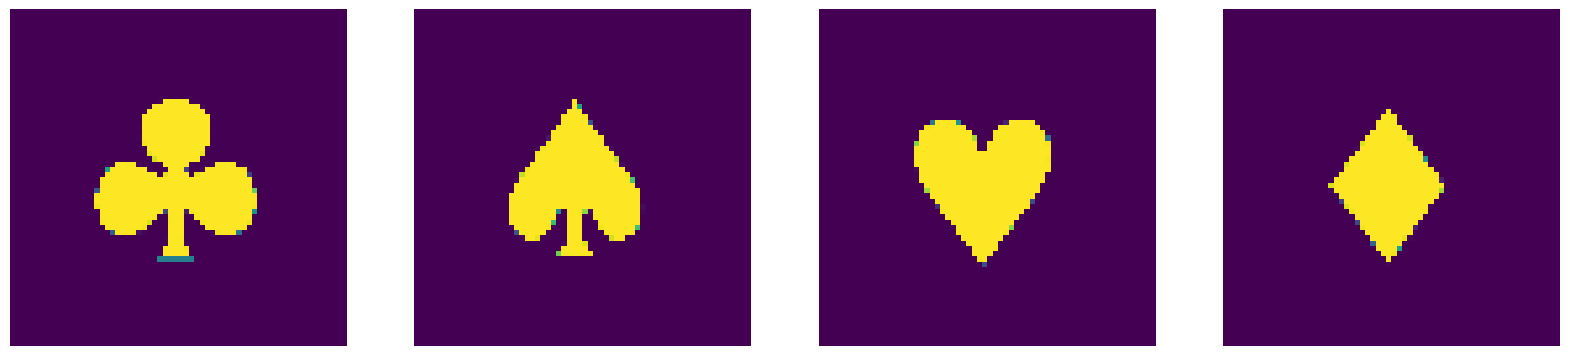

In [ ]:
cards = get_data()

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))
ax1.imshow(cards[0])
ax1.axis('off')
ax2.imshow(cards[1])
ax2.axis('off')
ax3.imshow(cards[2])
ax3.axis('off')
ax4.imshow(cards[3])
ax4.axis('off');

In [ ]:
# Labeled set (no transaltion, small rotations)
X_sup, y_sup = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=5, translation=None,
    samples=200, seed=0)
# Unlabeled set (translation, large rotations)
X_unsup, _ = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1,
    samples=3000, seed=1)
# Validation set (same as unlabeled, but using different seed)
X_val, y_val = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1,
    samples=1000, seed=2)

In [ ]:
X_unsup.shape

torch.Size([12000, 2304])

Here's the supervised part of our training set:

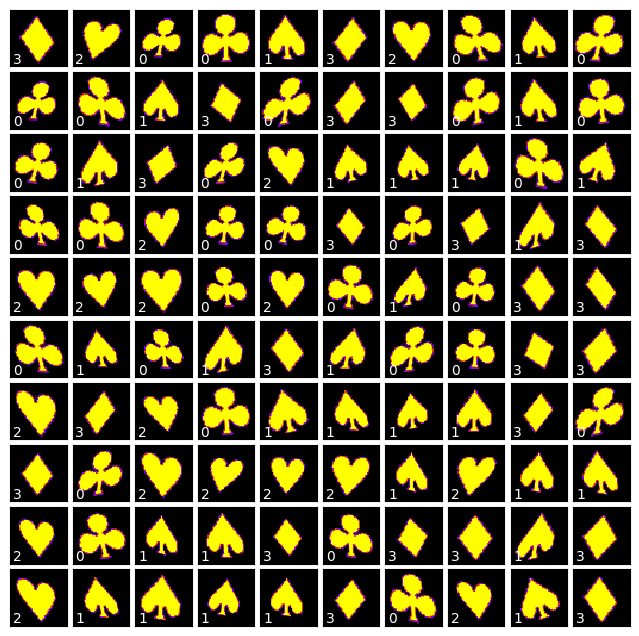

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_sup), size=(1,))
    im = X_sup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_sup[i].argmax().item()),
            transform=ax.transAxes, color='white')

... and this is the unsupervised one. Note that here we have much larger orientational disorder as long as random offsets (in other words, the rotations and translations of the unlabeled data come from a different distribution than those of the labeled data!)

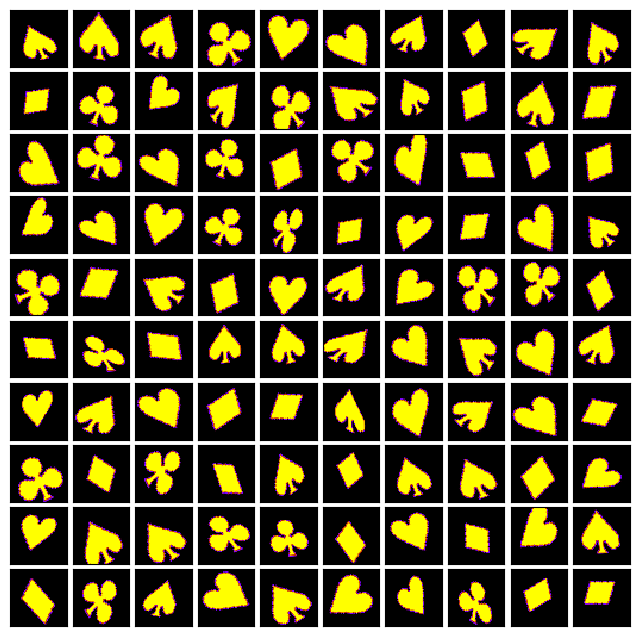

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_unsup), size=(1,))
    im = X_unsup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')

Next, we create dataloaders:

In [ ]:
(loader_unsup, loader_sup,
 loader_val) = pv.utils.init_ssvae_dataloaders(
     X_unsup, (X_sup, y_sup), (X_val, y_val), batch_size=64)

In [ ]:
r = len(loader_sup) / (len(loader_unsup) + len(loader_sup))
print("Ratio of labeled data: {}".format(r))

Ratio of labeled data: 0.06467661691542288


## Train ss-(tr)VAE model

Finally, we will train a semi supervised (ss) VAE model. The goal is to use a limited amount (~6%) of labeled data with small positional (orientation+translation) disorder to categorize large volumes of unlabeled data characterized by a (much) higher positional disorder. During the training, we are also going to enforce **t**ranslational and **r**otational invariance (hence, *ss-tr*VAE)

Epoch: 1 Training loss: 812.4127, Test accuracy: 0.2770
Epoch: 2 Training loss: 508.3167, Test accuracy: 0.4655
Epoch: 3 Training loss: 467.4359, Test accuracy: 0.4572
Epoch: 4 Training loss: 419.5881, Test accuracy: 0.5115
Epoch: 5 Training loss: 387.0867, Test accuracy: 0.5190
Epoch: 6 Training loss: 369.0790, Test accuracy: 0.5228
Epoch: 7 Training loss: 353.8225, Test accuracy: 0.4843
Epoch: 8 Training loss: 338.4824, Test accuracy: 0.4650
Epoch: 9 Training loss: 323.8400, Test accuracy: 0.4913
Epoch: 10 Training loss: 312.5150, Test accuracy: 0.5373


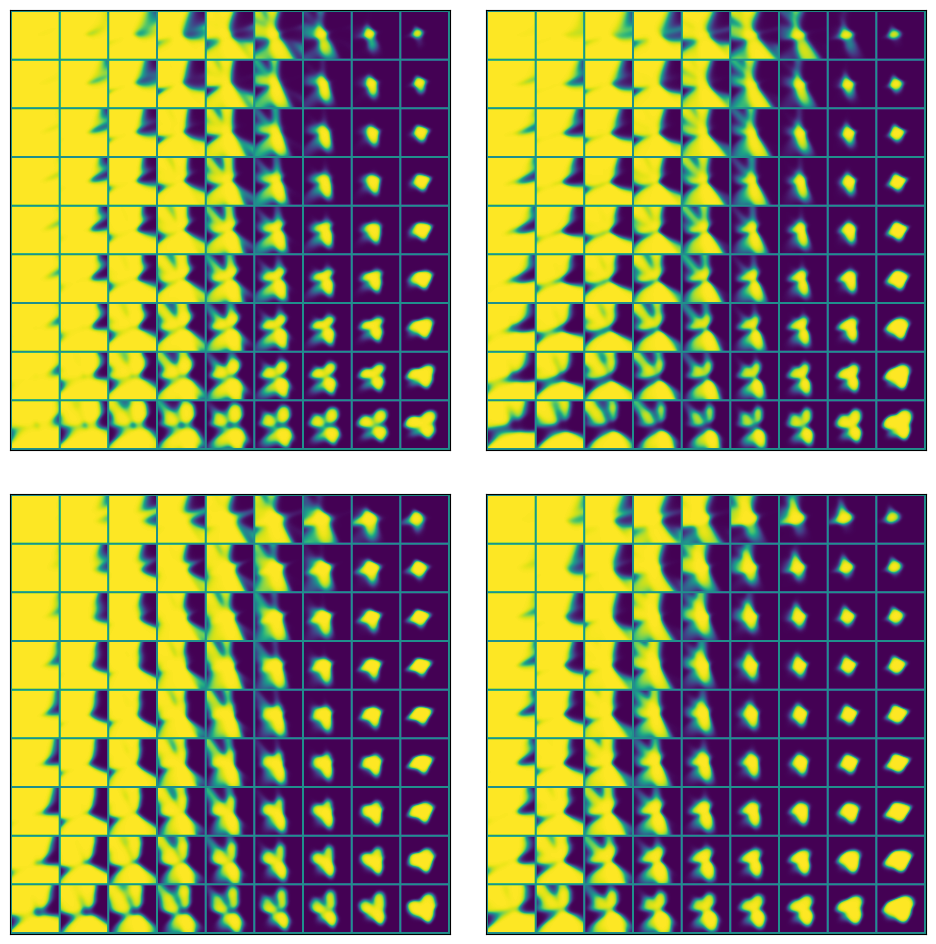

Epoch: 11 Training loss: 299.9111, Test accuracy: 0.5417
Epoch: 12 Training loss: 289.5213, Test accuracy: 0.5525
Epoch: 13 Training loss: 283.0386, Test accuracy: 0.5600
Epoch: 14 Training loss: 272.0124, Test accuracy: 0.5935
Epoch: 15 Training loss: 265.2776, Test accuracy: 0.6332
Epoch: 16 Training loss: 259.5798, Test accuracy: 0.6450
Epoch: 17 Training loss: 255.8179, Test accuracy: 0.6228
Epoch: 18 Training loss: 250.6550, Test accuracy: 0.6395
Epoch: 19 Training loss: 245.2502, Test accuracy: 0.6675
Epoch: 20 Training loss: 244.2933, Test accuracy: 0.6697


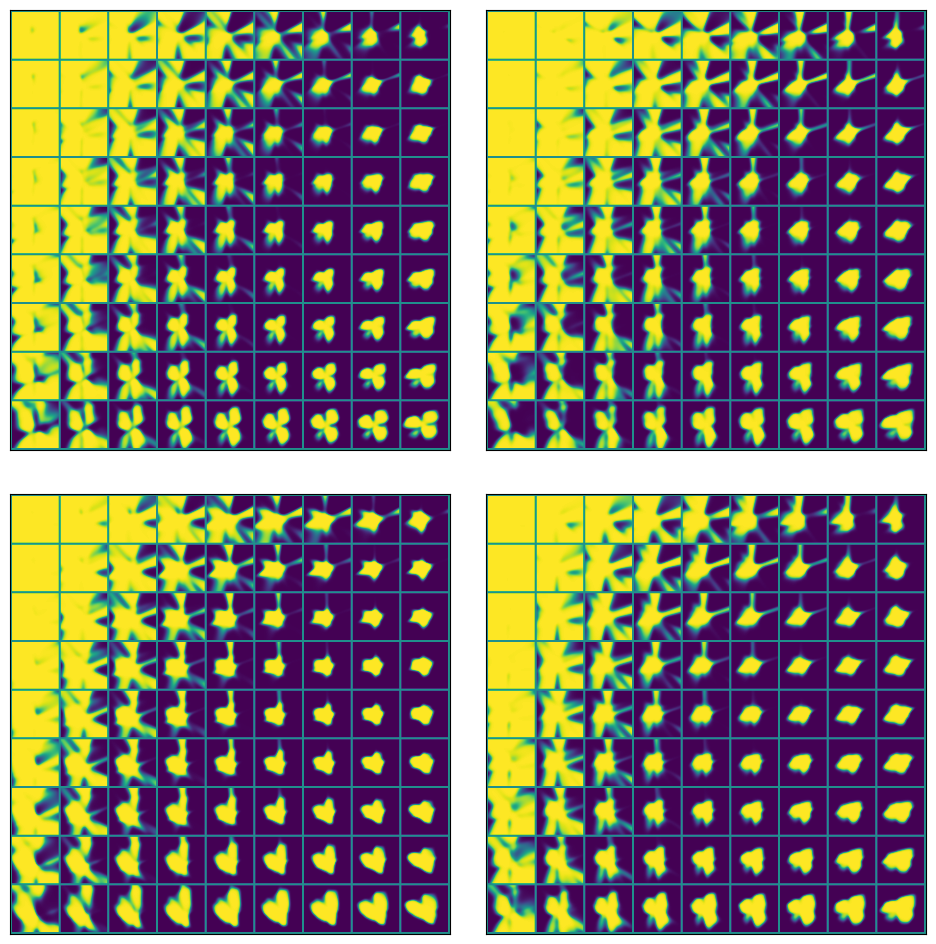

Epoch: 21 Training loss: 240.8456, Test accuracy: 0.6653
Epoch: 22 Training loss: 236.4193, Test accuracy: 0.6697
Epoch: 23 Training loss: 240.2731, Test accuracy: 0.7035
Epoch: 24 Training loss: 234.0197, Test accuracy: 0.6980
Epoch: 25 Training loss: 232.7269, Test accuracy: 0.6917
Epoch: 26 Training loss: 232.0623, Test accuracy: 0.6807
Epoch: 27 Training loss: 229.4330, Test accuracy: 0.6787
Epoch: 28 Training loss: 229.7599, Test accuracy: 0.7075
Epoch: 29 Training loss: 226.3991, Test accuracy: 0.7365
Epoch: 30 Training loss: 228.9765, Test accuracy: 0.7280


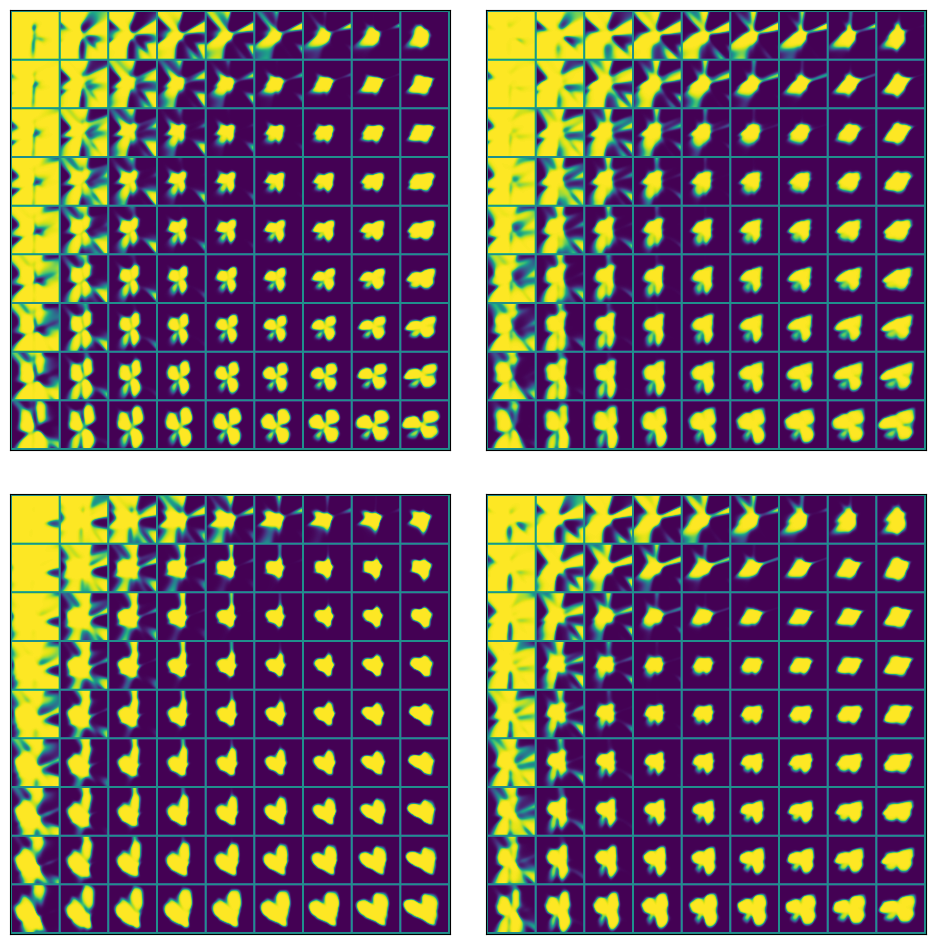

Epoch: 31 Training loss: 221.7051, Test accuracy: 0.7245
Epoch: 32 Training loss: 222.0025, Test accuracy: 0.7220
Epoch: 33 Training loss: 218.5701, Test accuracy: 0.7388
Epoch: 34 Training loss: 221.6758, Test accuracy: 0.7255
Epoch: 35 Training loss: 218.1075, Test accuracy: 0.7320
Epoch: 36 Training loss: 216.1512, Test accuracy: 0.7442
Epoch: 37 Training loss: 215.8030, Test accuracy: 0.7668
Epoch: 38 Training loss: 214.3096, Test accuracy: 0.7665
Epoch: 39 Training loss: 212.1788, Test accuracy: 0.7903
Epoch: 40 Training loss: 211.0699, Test accuracy: 0.7740


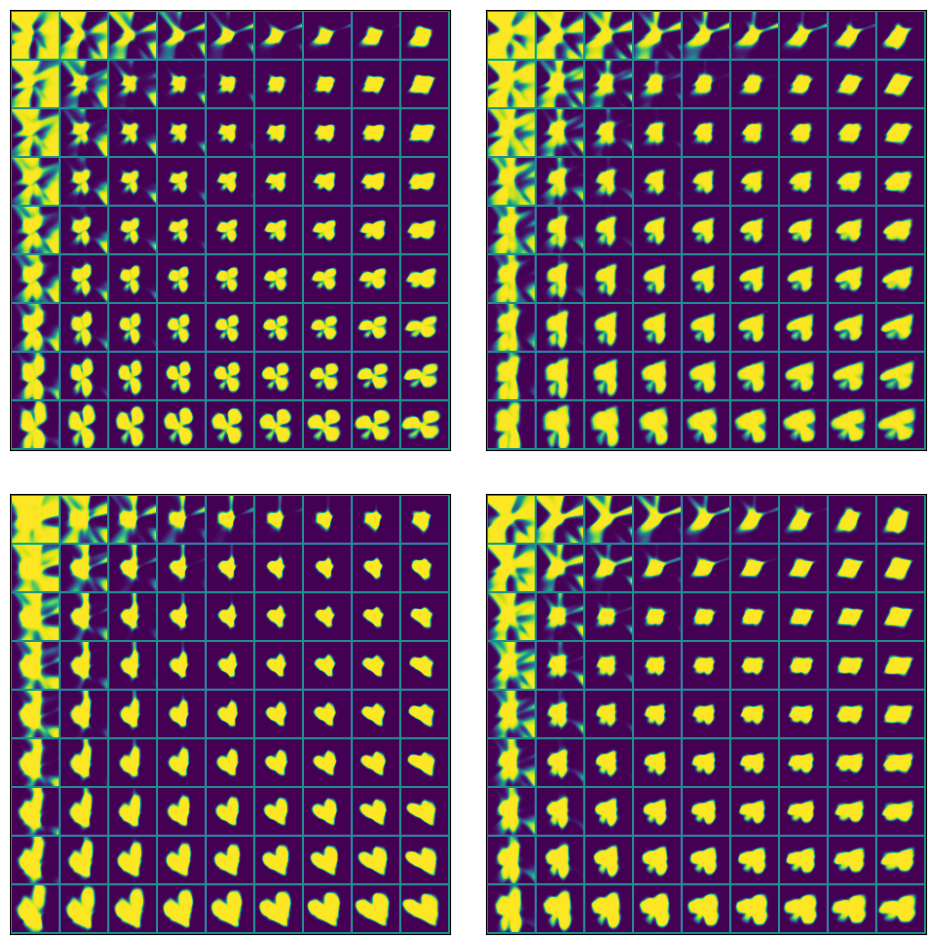

Epoch: 41 Training loss: 209.2535, Test accuracy: 0.7522
Epoch: 42 Training loss: 210.6548, Test accuracy: 0.7925
Epoch: 43 Training loss: 207.5949, Test accuracy: 0.7400
Epoch: 44 Training loss: 207.1300, Test accuracy: 0.7750
Epoch: 45 Training loss: 204.5264, Test accuracy: 0.7825
Epoch: 46 Training loss: 205.1467, Test accuracy: 0.7943
Epoch: 47 Training loss: 203.3749, Test accuracy: 0.7940
Epoch: 48 Training loss: 201.6477, Test accuracy: 0.7973
Epoch: 49 Training loss: 200.2546, Test accuracy: 0.7768
Epoch: 50 Training loss: 200.2530, Test accuracy: 0.7802


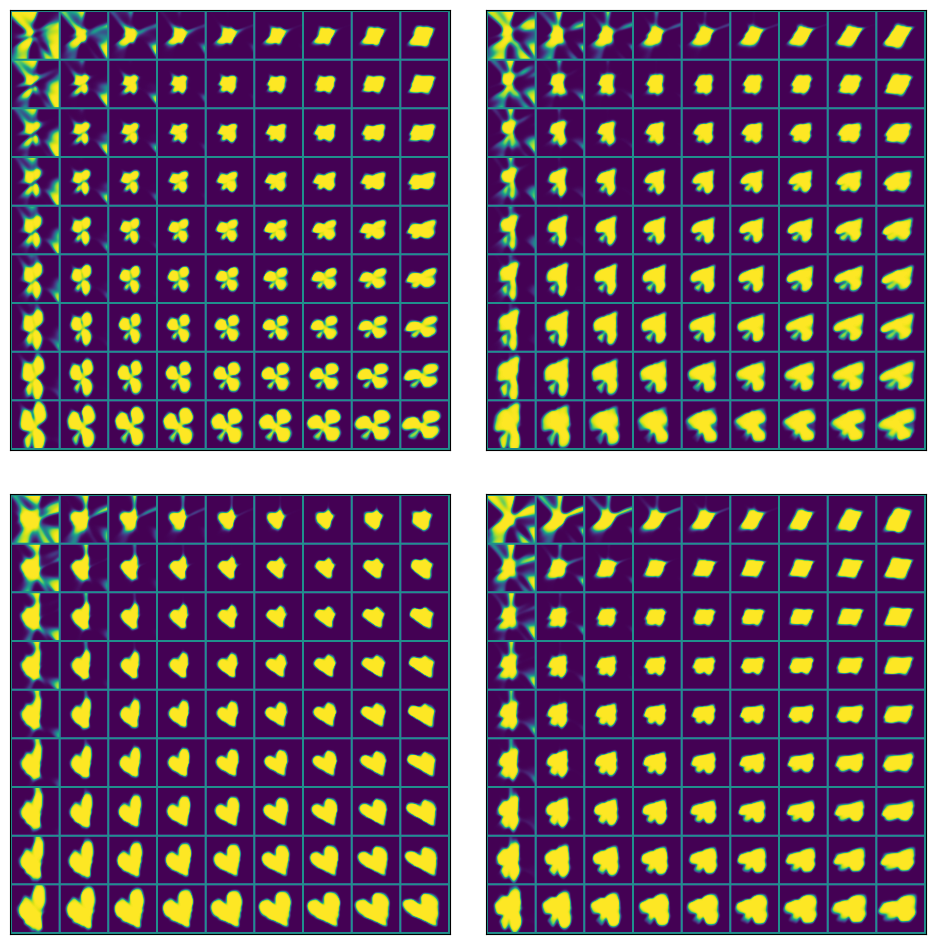

Epoch: 51 Training loss: 198.2200, Test accuracy: 0.8065
Epoch: 52 Training loss: 195.4577, Test accuracy: 0.7450
Epoch: 53 Training loss: 198.2786, Test accuracy: 0.7933
Epoch: 54 Training loss: 195.5058, Test accuracy: 0.7907
Epoch: 55 Training loss: 193.9741, Test accuracy: 0.7728
Epoch: 56 Training loss: 191.8993, Test accuracy: 0.7885
Epoch: 57 Training loss: 191.4055, Test accuracy: 0.7930
Epoch: 58 Training loss: 190.5092, Test accuracy: 0.8100
Epoch: 59 Training loss: 188.9308, Test accuracy: 0.8147
Epoch: 60 Training loss: 185.3972, Test accuracy: 0.7672


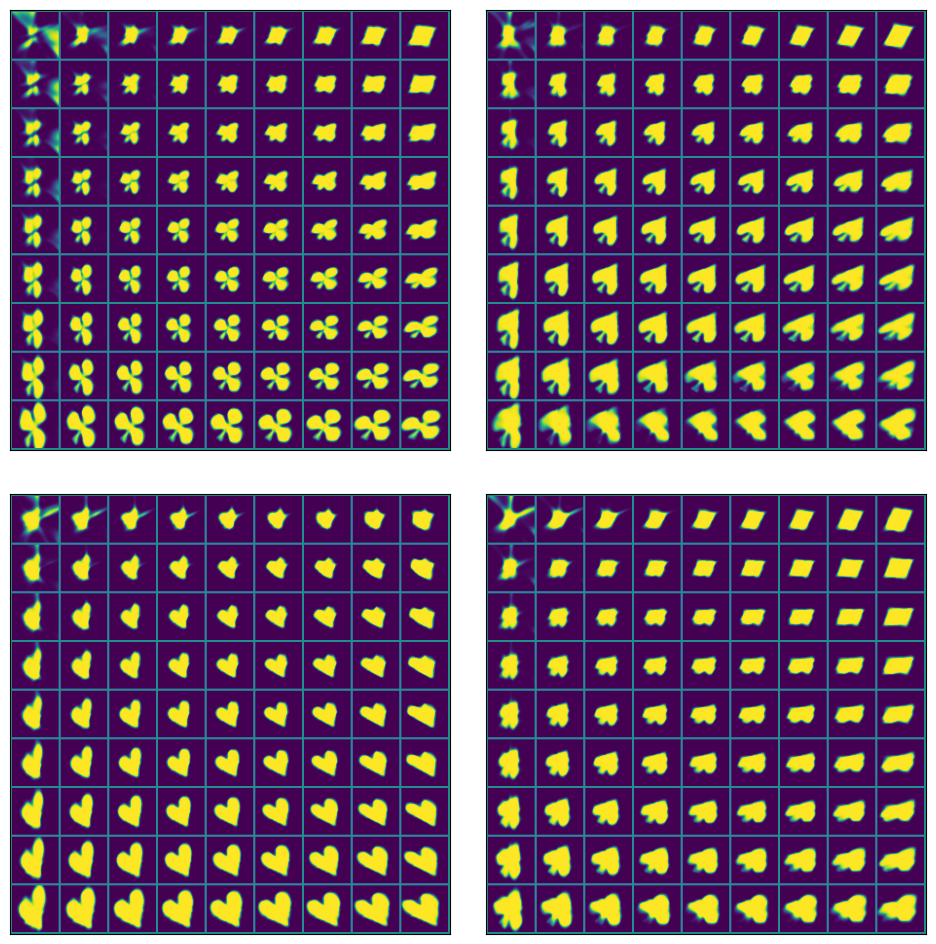

Epoch: 61 Training loss: 185.2035, Test accuracy: 0.7920
Epoch: 62 Training loss: 183.6367, Test accuracy: 0.7915
Epoch: 63 Training loss: 181.2608, Test accuracy: 0.8073
Epoch: 64 Training loss: 179.6377, Test accuracy: 0.8140
Epoch: 65 Training loss: 178.9427, Test accuracy: 0.8090
Epoch: 66 Training loss: 179.1182, Test accuracy: 0.8025
Epoch: 67 Training loss: 178.0937, Test accuracy: 0.8035
Epoch: 68 Training loss: 178.9303, Test accuracy: 0.7588
Epoch: 69 Training loss: 175.5959, Test accuracy: 0.8165
Epoch: 70 Training loss: 174.9865, Test accuracy: 0.8127


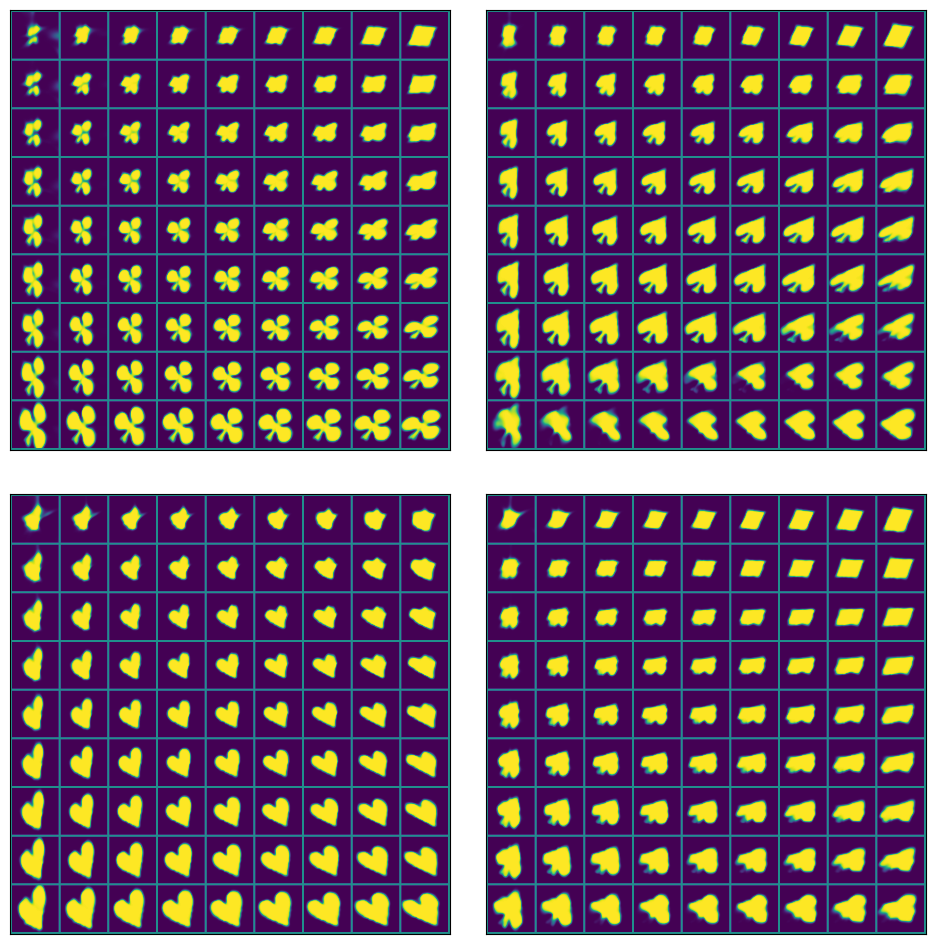

Epoch: 71 Training loss: 173.4471, Test accuracy: 0.8213
Epoch: 72 Training loss: 172.0842, Test accuracy: 0.8210
Epoch: 73 Training loss: 172.4296, Test accuracy: 0.8095
Epoch: 74 Training loss: 171.1078, Test accuracy: 0.8420
Epoch: 75 Training loss: 173.9090, Test accuracy: 0.8057
Epoch: 76 Training loss: 173.0893, Test accuracy: 0.8267
Epoch: 77 Training loss: 168.9142, Test accuracy: 0.8250
Epoch: 78 Training loss: 169.6150, Test accuracy: 0.8060
Epoch: 79 Training loss: 169.6477, Test accuracy: 0.8297
Epoch: 80 Training loss: 168.1214, Test accuracy: 0.8145


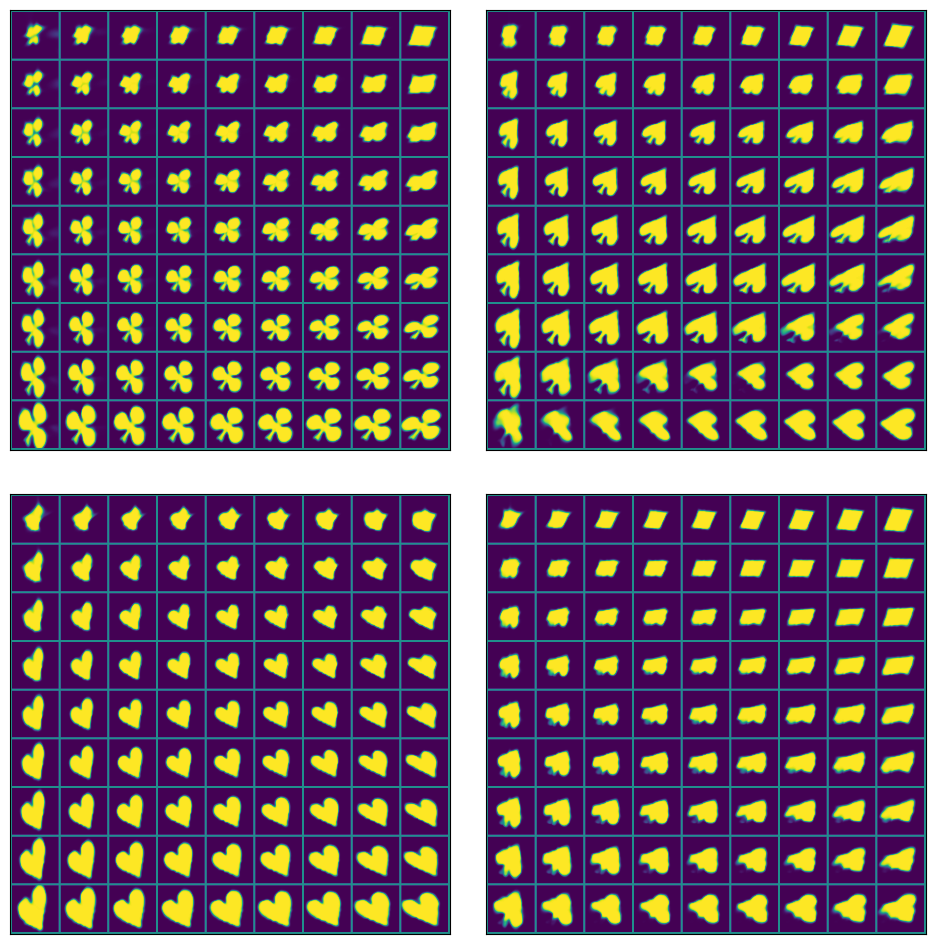

Epoch: 81 Training loss: 169.0778, Test accuracy: 0.8317
Epoch: 82 Training loss: 173.7431, Test accuracy: 0.8133
Epoch: 83 Training loss: 167.8868, Test accuracy: 0.8287
Epoch: 84 Training loss: 165.6279, Test accuracy: 0.8127
Epoch: 85 Training loss: 165.8942, Test accuracy: 0.8440
Epoch: 86 Training loss: 168.6719, Test accuracy: 0.8458
Epoch: 87 Training loss: 167.4549, Test accuracy: 0.8448
Epoch: 88 Training loss: 167.4674, Test accuracy: 0.8440
Epoch: 89 Training loss: 168.7996, Test accuracy: 0.8227
Epoch: 90 Training loss: 166.1190, Test accuracy: 0.8413


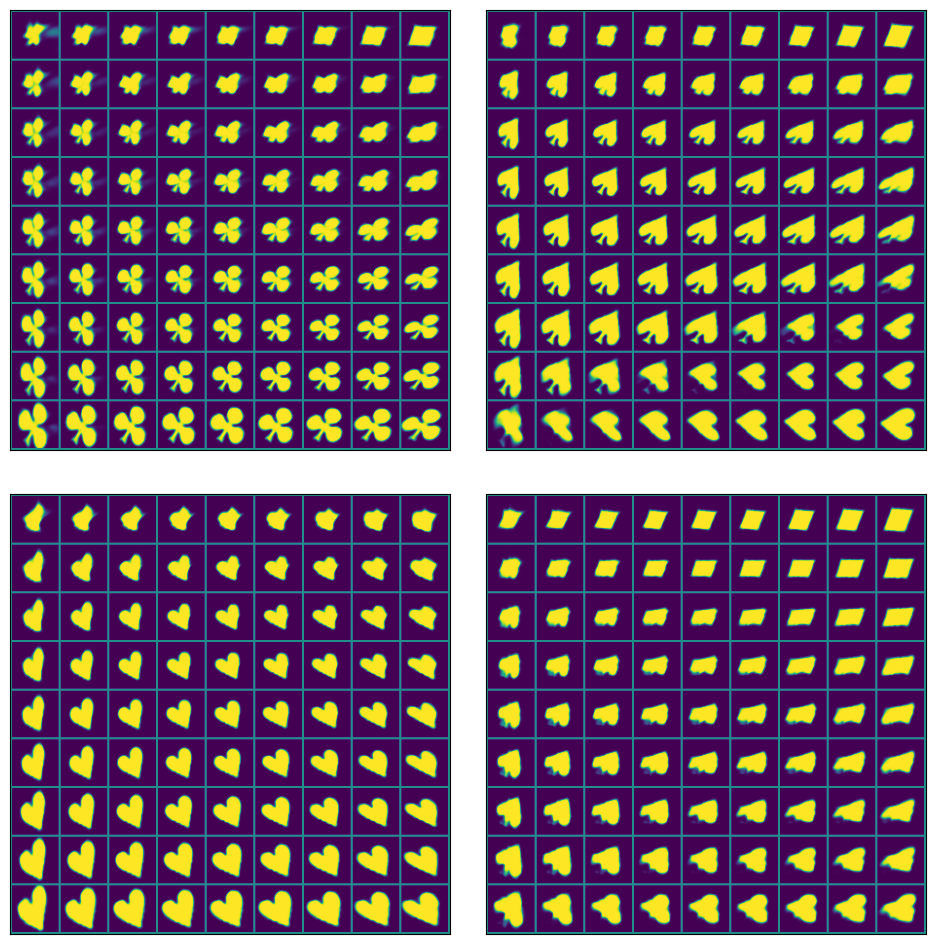

Epoch: 91 Training loss: 167.6584, Test accuracy: 0.8055
Epoch: 92 Training loss: 163.3013, Test accuracy: 0.8397
Epoch: 93 Training loss: 163.8871, Test accuracy: 0.8500
Epoch: 94 Training loss: 163.2202, Test accuracy: 0.8420
Epoch: 95 Training loss: 162.5005, Test accuracy: 0.8442
Epoch: 96 Training loss: 162.2299, Test accuracy: 0.8450
Epoch: 97 Training loss: 160.8874, Test accuracy: 0.8420
Epoch: 98 Training loss: 162.5166, Test accuracy: 0.8310
Epoch: 99 Training loss: 164.7981, Test accuracy: 0.8415
Epoch: 100 Training loss: 162.4649, Test accuracy: 0.8403


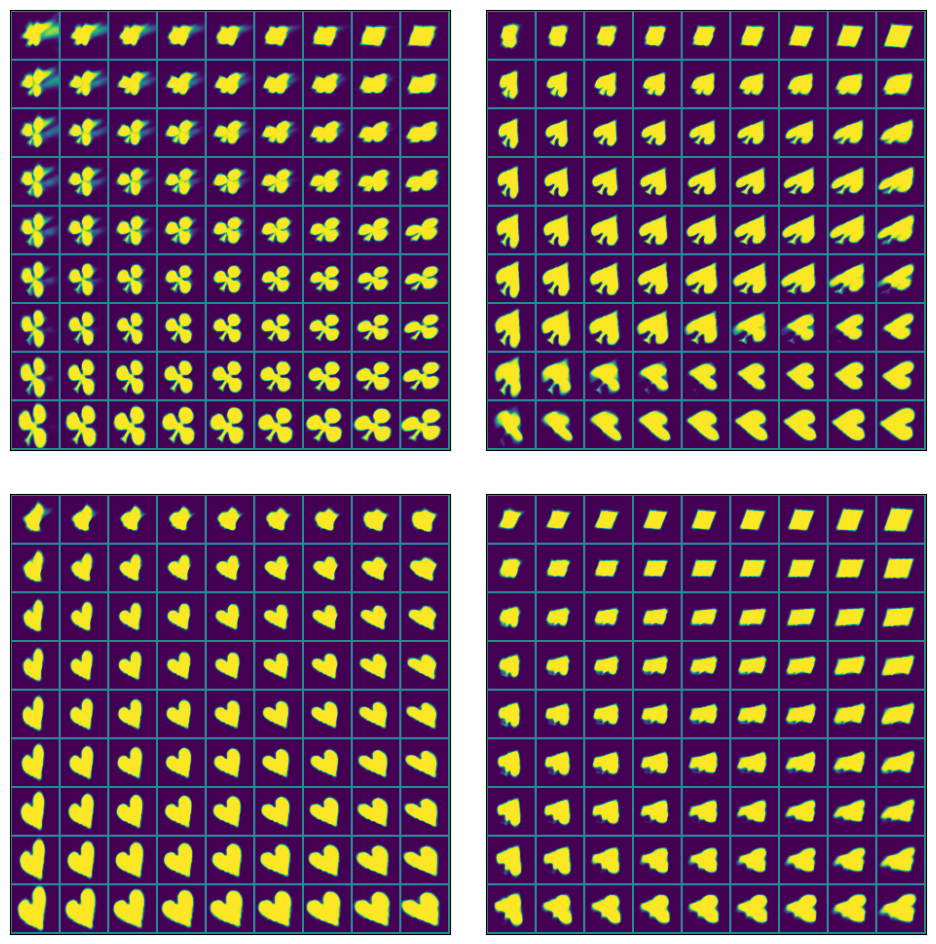

In [ ]:
data_dim = (48, 48)
latent_dim = 2
num_classes = 4

# Initialize model
ssvae = pv.models.ssiVAE(
    data_dim, latent_dim, num_classes, invariances=['r', 't'])

# Initialize trainer
trainer = pv.trainers.auxSVItrainer(ssvae)

# We're going to ramp-up KL weight from 1 to 2 in the first 30 epochs
kl_scale = torch.linspace(1, 2, 30)
# Train model for n epochs
for e in range(100):
    sc = kl_scale[e] if e < len(kl_scale) else kl_scale[-1]
    trainer.step(loader_unsup, loader_sup, loader_val,
                 aux_loss_multiplier=30, scale_factor=sc)
    trainer.print_statistics()
    # Plot learned latent manifolds every 10 epoch
    if (e+1) % 10 == 0:
        plot_manifolds(ssvae)

Looks like we achieved ~87% accuracy with only ~6% of the data labeled! Furthermore, we were able to disentangle two main factors of data variation (beyond rotations and translations), namely, shear deformation and scale, which are encoded in the first (left to right) and second (top to bottom) latent variables.

We can also plot traversals of the learned manifold where the horizontal direction corresponds to one of the continuous latent variables (while the other one is fixed at 0) and the vertical direction corresponds to the categorical variable:

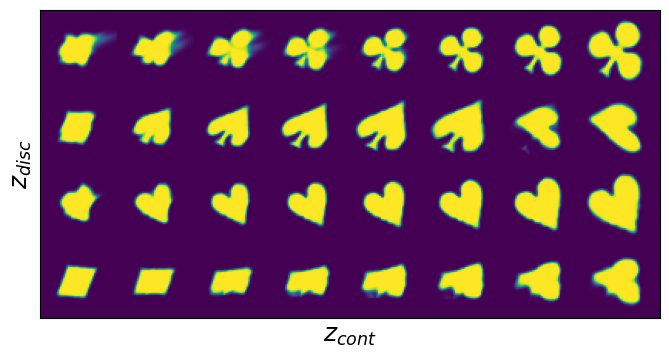

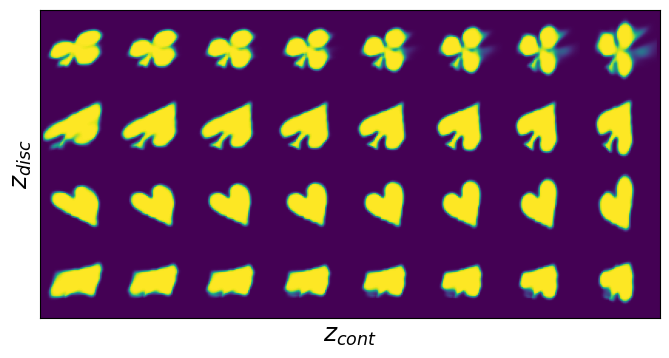

In [ ]:
for i in range(2):
    ssvae.manifold_traversal(8, i, cmap='viridis')

## Confunsion Matrix Plot to look at the mislabeling

*Performed by Youngtao Liu*

In [ ]:
# Make a data set for confusion matrix analysis
x_test, y_test = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1,
    samples=3000, seed=2)

In [ ]:
z_mu, _, c_test = ssvae.encode(x_test)

In [ ]:
#get prediction and true class
y_pred = np.array(c_test)  #prediction

y = np.array(y_test)
yy = np.where(y==1)
y_true = yy[1]    #true class

In [ ]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize =15)
    plt.yticks(tick_marks, classes, rotation=45, fontsize = 15)
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)

Normalized confusion matrix
[[9.96666667e-01 3.00000000e-03 0.00000000e+00 3.33333333e-04]
 [3.33333333e-04 9.98333333e-01 0.00000000e+00 1.33333333e-03]
 [0.00000000e+00 4.15333333e-01 5.84333333e-01 3.33333333e-04]
 [2.33333333e-03 2.18000000e-01 0.00000000e+00 7.79666667e-01]]


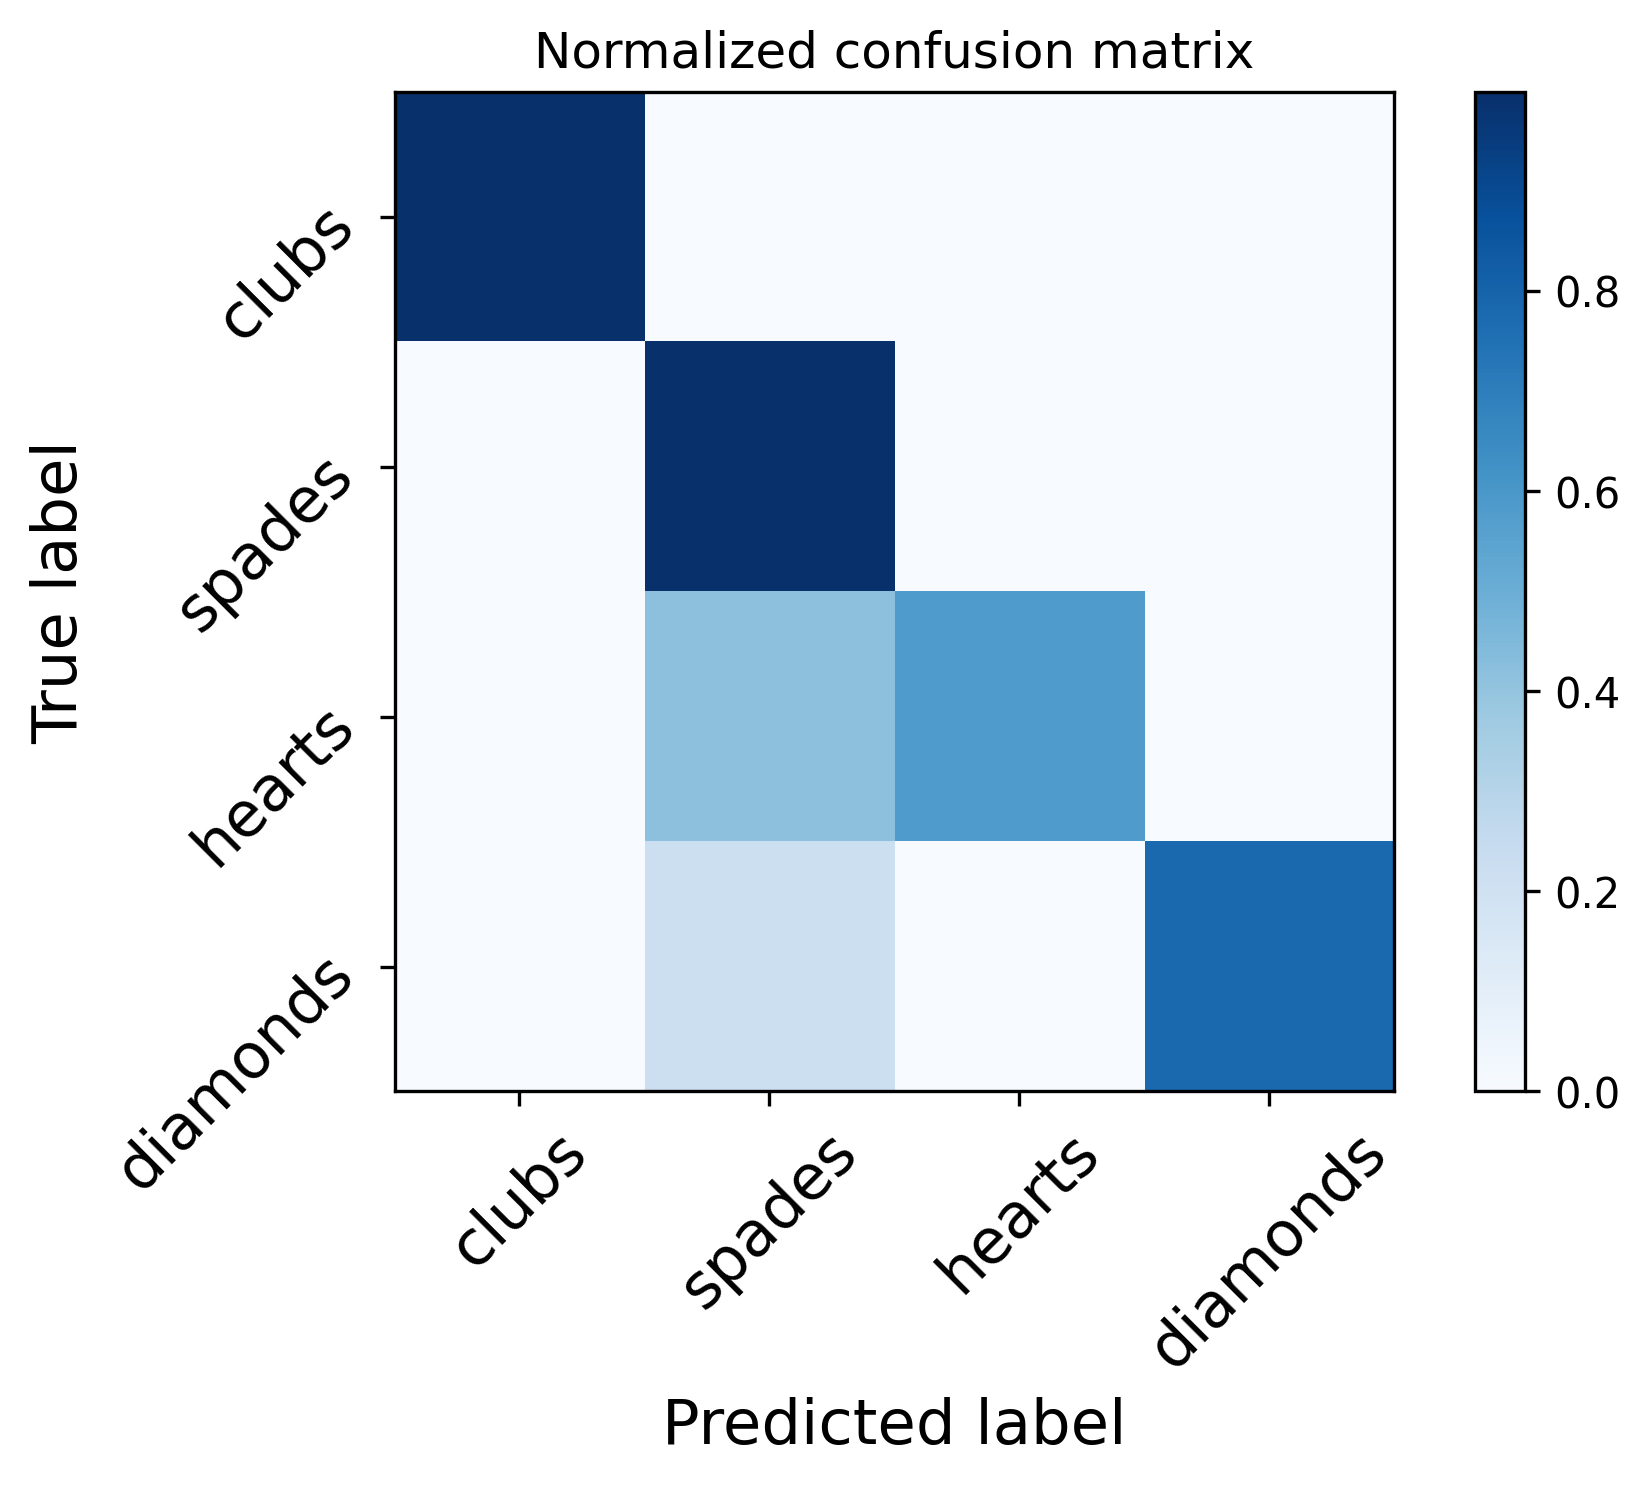

In [ ]:
class_names = ['clubs', 'spades', 'hearts', 'diamonds']

#show confusion matrix plot
plt.figure(dpi=300)
plot_confusion_matrix(c_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Add noise to x_test

*Performed by Youngtao Liu*



*   Here I added two kinds of noise, one called background noise, the other called contaminaiton noise
*   Background noise: add background signal; this noise is determined by a noise_level parameter, which defines the intesnity of background
*   Contamination noise: add high-intensity signals in random pixels, this stimulates the contamination spot in experimental images. This noise is determined by contamination_level and contaminaiton_density, which defines the intensity and density of contamination, respectively.



In [ ]:
#make a data set for confusion matrix analysis
x_test, y_test = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1,
    samples=1000, seed=2)

#find out y_true first
y = np.array(y_test)
yy = np.where(y==1)
y_true = yy[1]    #true class

Background noise function

In [ ]:
#define a function to add background noise
def add_noise (imgs, img_num=0, noise_level=0.1):   #input includes x_test data, number of x_test images, and noise level
  img = np.array(imgs)
  resp_imgs = img.reshape(img_num,48,48)
  for i in range (img_num):
    original = resp_imgs[i]
    noise = np.random.normal(0, noise_level, original.shape)
    resp_imgs[i] = original + noise

  return resp_imgs.reshape(img_num, 2304)

Contamination noise function

In [ ]:
#define a function to add contamination noise
def add_contamination (imgs, img_num, ctm_intensity = 0, ctm_density = 0.1): #input includes x_test data, number of x_test images, contaminaton level and contamination density
  img = np.array(imgs)

  for i in range (img_num):
    p=np.random.permutation(2304)
    img[i][p[:int(2304*ctm_density)]]=ctm_intensity

  return img

Look noise image and contaminated image

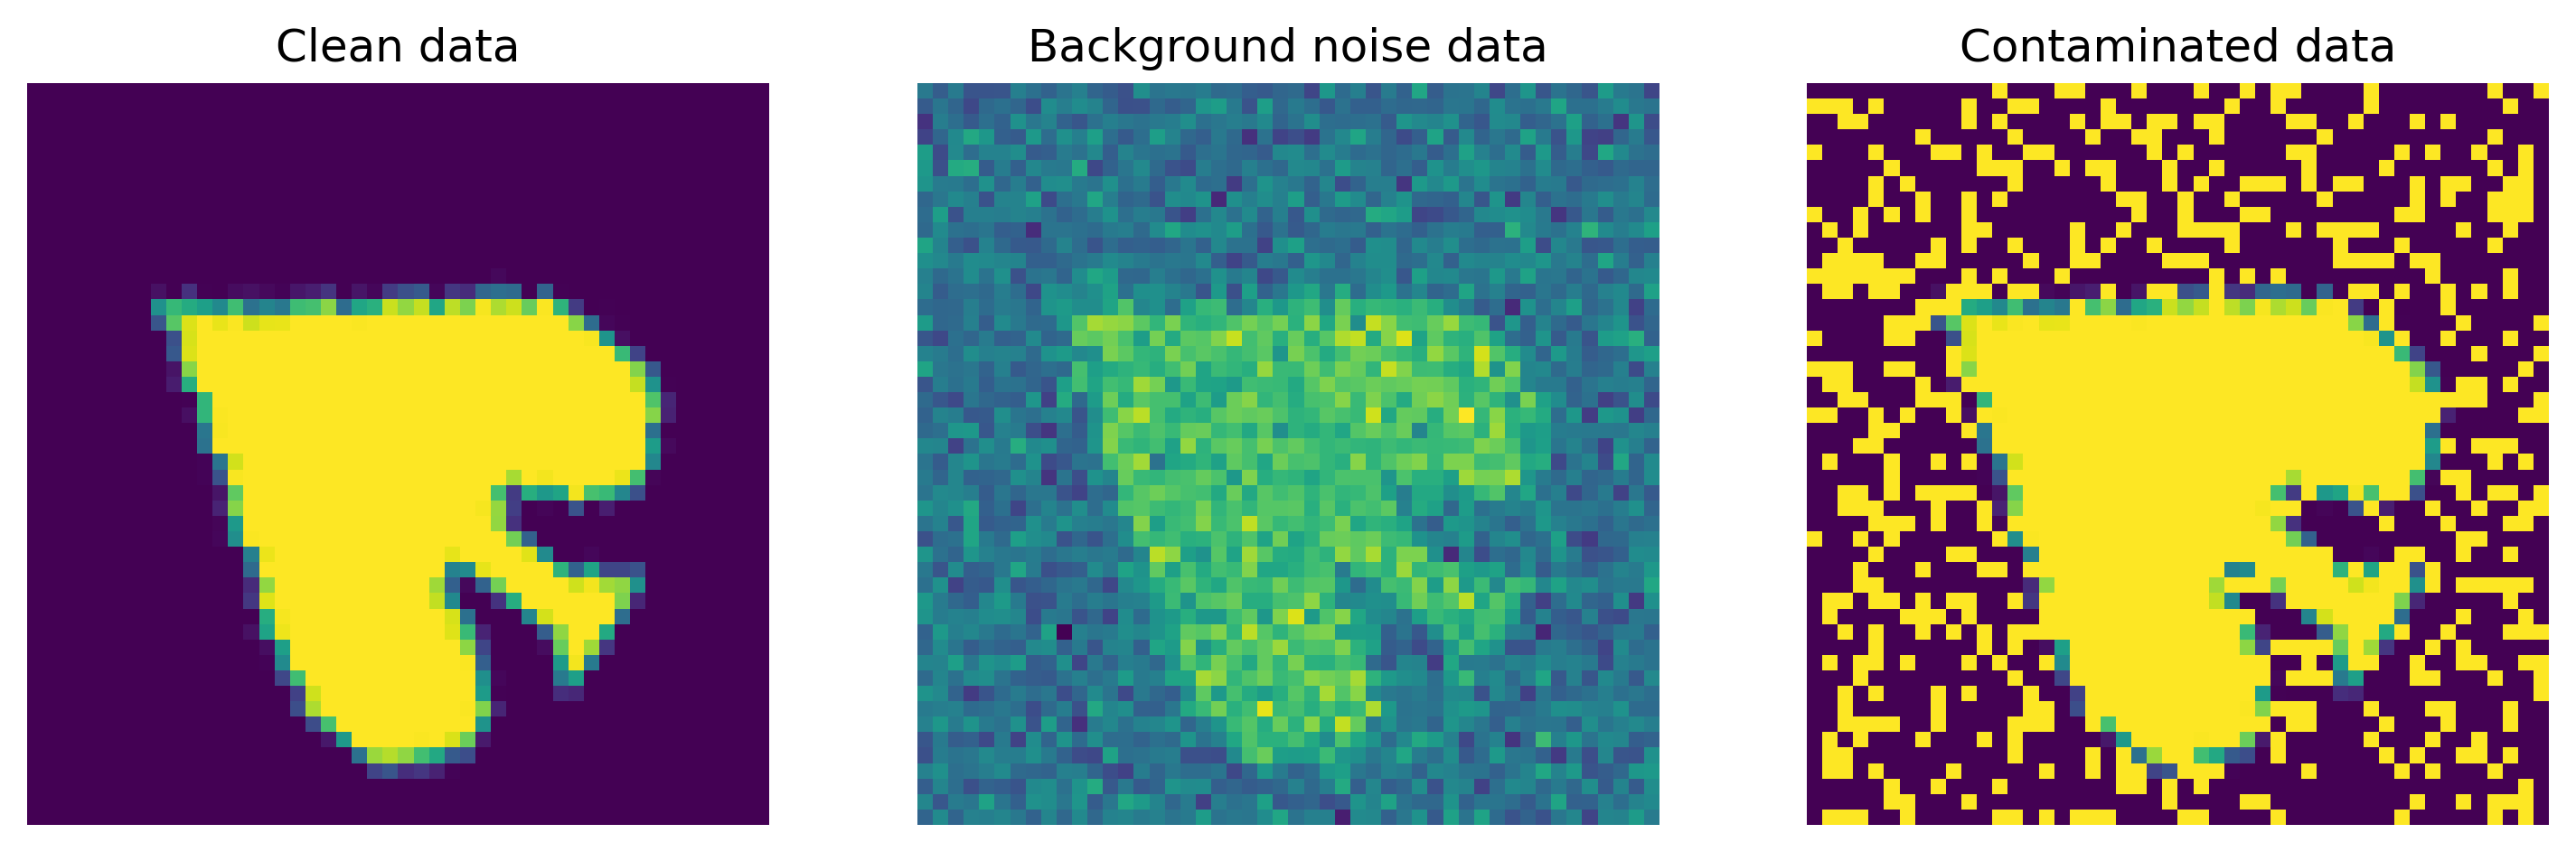

In [ ]:
noise_x_test = add_noise(x_test, img_num = 4000, noise_level=0.3)
ctm_x_test = add_contamination(x_test, img_num = 4000, ctm_intensity = 1, ctm_density = 0.3)

k =1000
f, (ax1, ax2, ax3)= plt.subplots(1,3, figsize = (12,4), dpi=300)
ax1.imshow(x_test[k].view(48,48))
ax1.axis('off')
ax1.set_title('Clean data')

ax2.imshow(noise_x_test[k].reshape(48,48))
ax2.set_title('Background noise data')
ax2.axis('off')

ax3.imshow(ctm_x_test[k].reshape(48,48))
ax3.set_title('Contaminated data')
ax3.axis('off')
plt.show()

Analyze noise data using pre-trained model

(0.2, 0.9)

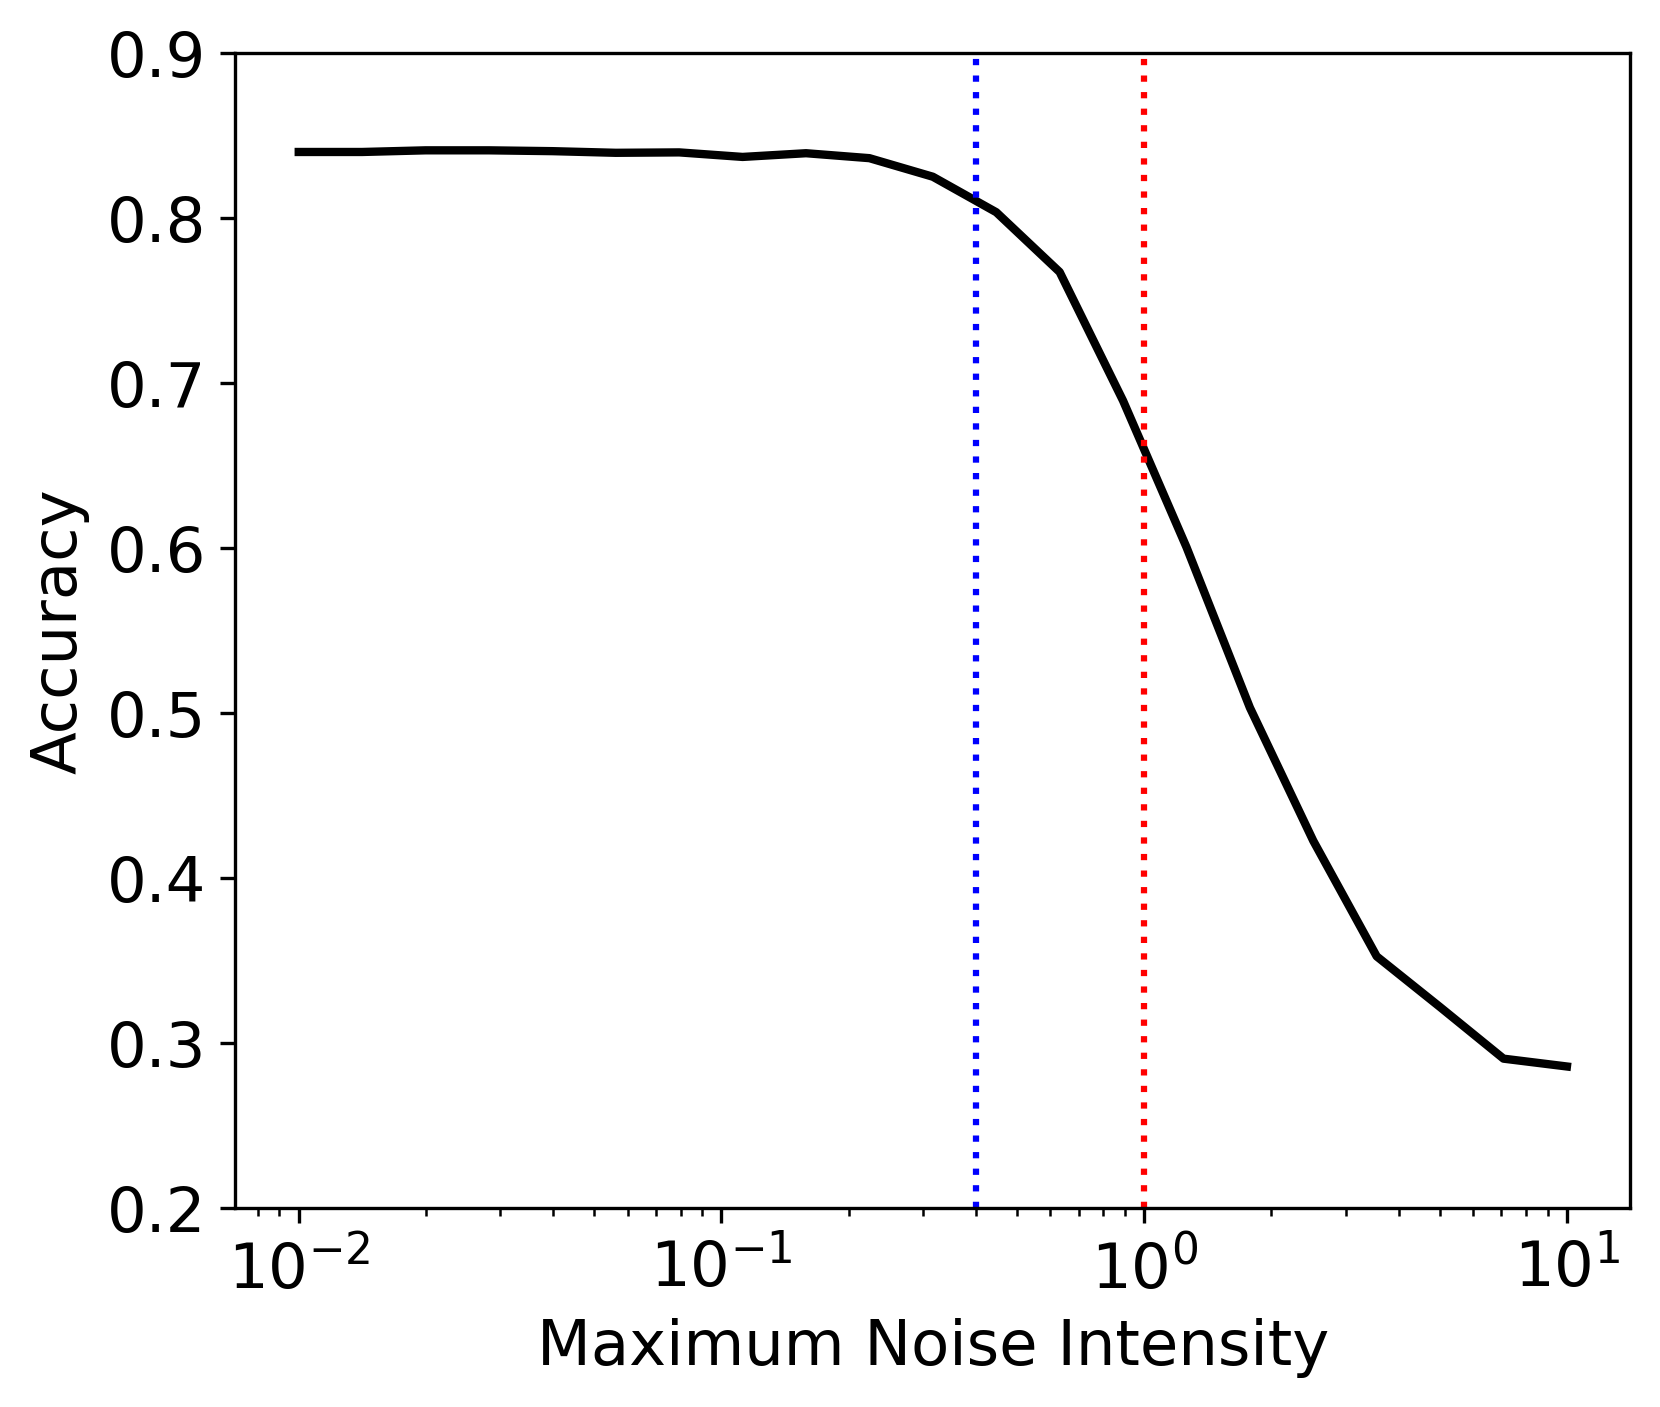

In [ ]:
noise = np.linspace(-2,1,21)
noise_l = 10**noise
scores = []

for i in noise_l:
  noise_x_test = add_noise(x_test, img_num = 4000, noise_level=i)
  test = torch.from_numpy(noise_x_test)
  z_mu, _, c_test = ssvae.encode(test)
  y_pred = np.array(c_test)
  score = (y_pred==y_true).sum()
  scores.append(score)

s = np.array(scores)/4000

f, ax = plt.subplots(figsize = (6,5), dpi=300)
plt.plot(noise_l, s, c = 'black', linewidth = 2)
plt.xscale('log')
plt.xlabel('Maximum Noise Intensity', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.axvline(x = 1, linestyle=":", c = 'r')
plt.axvline(x = 0.4, linestyle=":", c = 'b')
plt.tick_params('both', labelsize=15 )
plt.ylim(0.2,0.9)

Analyze contaminated data using pre-trained model

In [ ]:
ctm_l = np.linspace(0,1,11)
ctm_d = np.linspace(0,0.5,11)

c_score_2D = np.zeros((11,11))

for i in range (11):
  for j in range (11):
    ctm_x_test = add_contamination(x_test, img_num = 4000, ctm_intensity = ctm_l[i], ctm_density = ctm_d[j])
    test = torch.from_numpy(ctm_x_test)
    z_mu, _, c_test = ssvae.encode(test)
    y_pred = np.array(c_test)
    score = (y_pred==y_true).sum()
    c_score_2D[i,j] = score

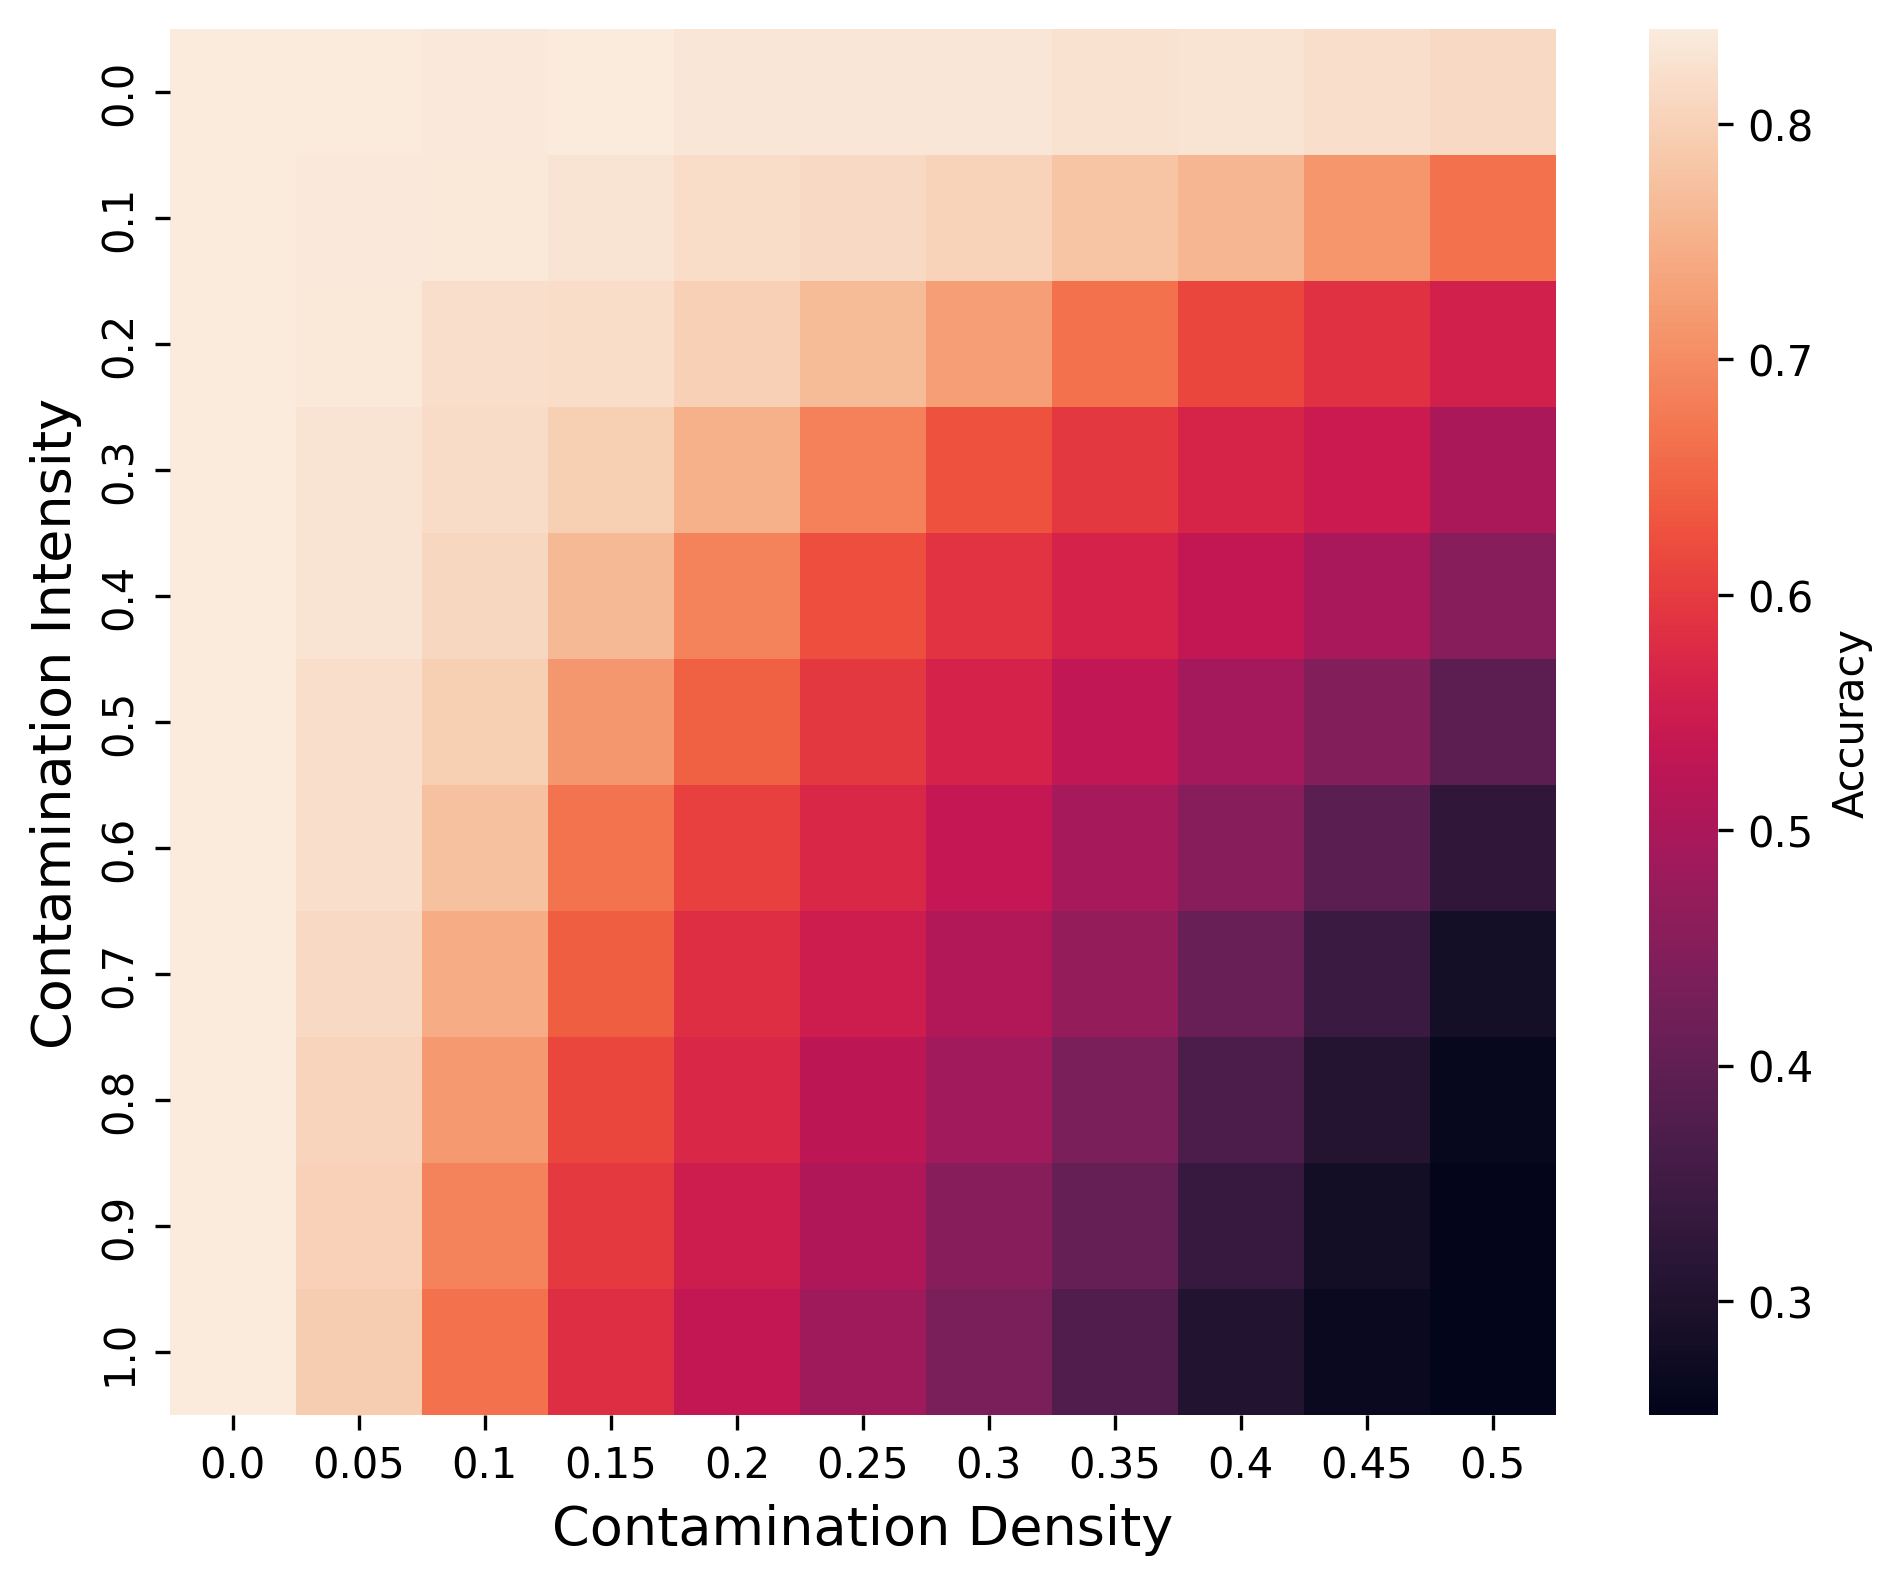

In [ ]:
#heat map
import seaborn as sns

c_s_2D = np.array(c_score_2D)/4000

f, ax = plt.subplots(figsize = (8,6), dpi=300)
ax = sns.heatmap(c_s_2D, xticklabels=np.around(ctm_d,2), yticklabels=np.around(ctm_l,2), annot = False, square = True, cbar_kws={'label':'Accuracy'})
ax.set_ylabel ('Contamination Intensity', fontsize = 13)
ax.set_xlabel ('Contamination Density', fontsize = 13)
plt.show()

## Add more distortions

*Performed by Youngtao Liu*

Analyze data with varying shear and rotation using pre-trained model

In [ ]:
sr = np.linspace(0,30,16)  #shear
ag = np.linspace(0,180, 16) #angle
score_2D = np.zeros((16,16)) #to store score

In [ ]:
for i in range (16):
  for j in range (16):
    x_test, y_test = transform_images(*cards, shear=sr[i], scale=(1, 1.3), angle=ag[j], translation=0.1, samples=1000, seed=2)
    z_mu, _, c_test = ssvae.encode(x_test)
    y_pred = np.array(c_test)
    y = np.array(y_test)
    yy = np.where(y==1)
    y_true = yy[1]    #true class
    score = (y_pred==y_true).sum()
    score_2D[i,j] = score

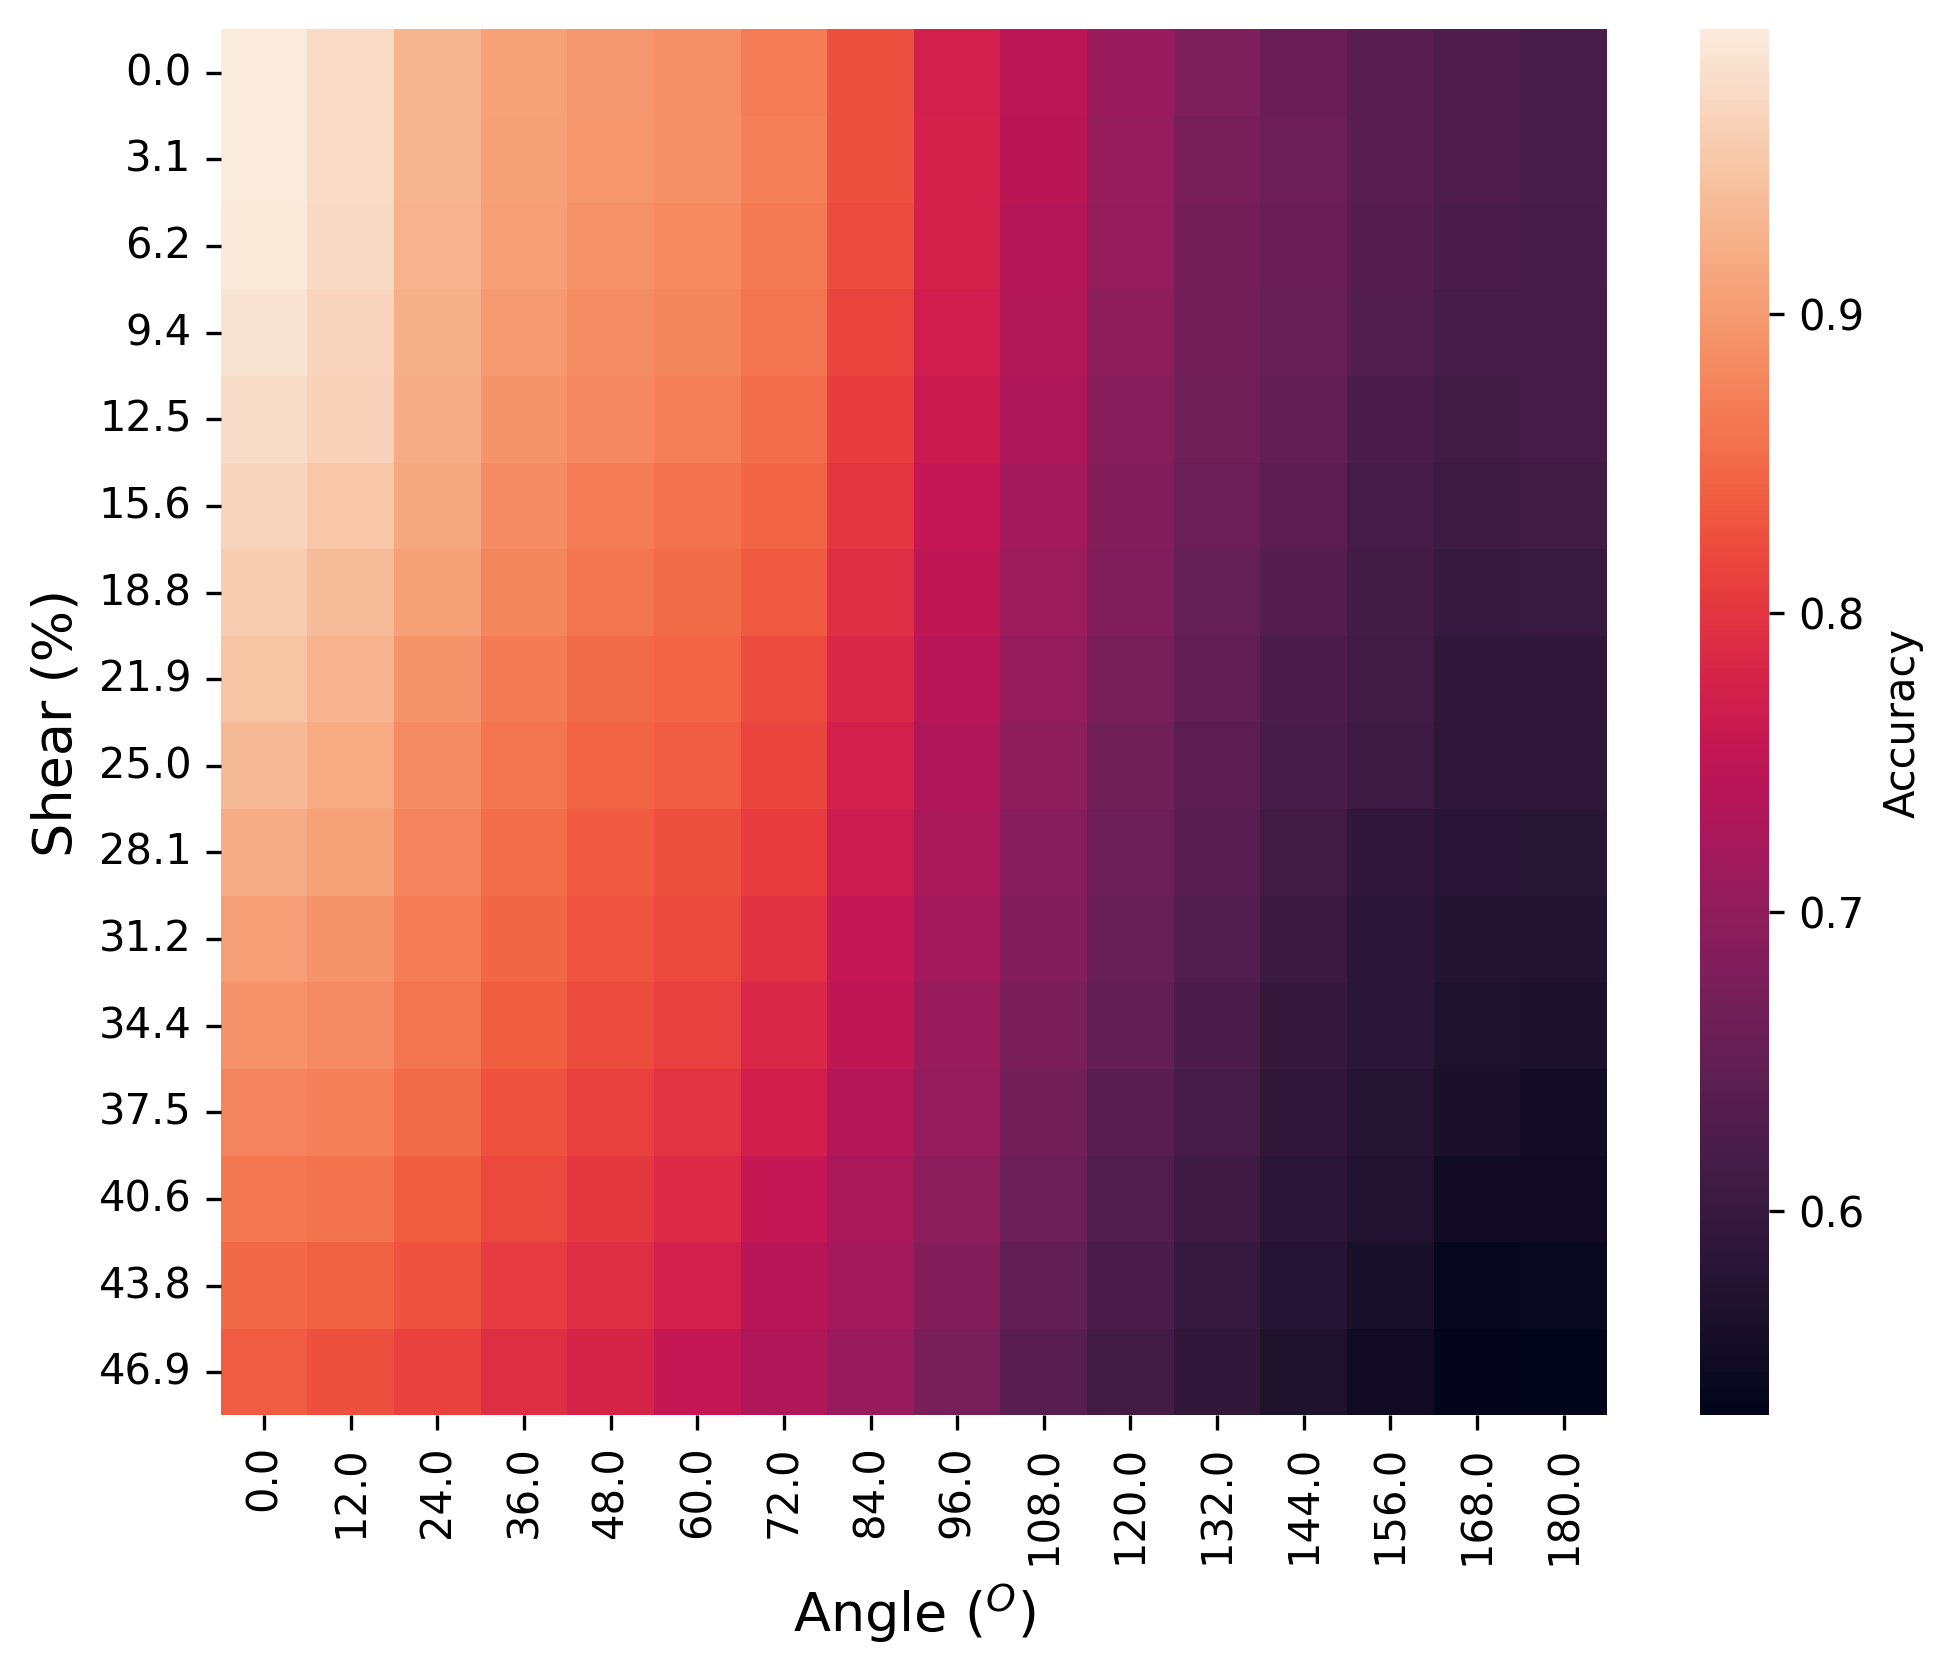

In [ ]:
#heat map
ss_2D = np.array(score_2D)/4000

f, ax = plt.subplots(figsize = (8,6), dpi=300)
ax = sns.heatmap(ss_2D, xticklabels=ag, yticklabels=np.around(sr*100/64,1), annot = False, square = True, cbar_kws={'label':'Accuracy'})
ax.set_ylabel ('Shear (%)', fontsize = 13)
ax.set_xlabel ('Angle ($^O$)', fontsize = 13)
plt.show()